## Figure S12 - Estimate the Lava Dome Volume from the DEM error during the time series analysis

1. Use higher temporal coherence threshold (0.95) to discard noisy pixels
2. Apply a local reference point to convert the relative DEM error into the local lava dome thickness.
3. Calc the mean lava tickness from asc. and desc orbits
4. Calc the volume within the crater

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt, ticker
from cartopy import crs as ccrs
from skimage.transform import resize
from mintpy.objects import deramp
from mintpy.utils import readfile, writefile, utils as ut, attribute as attr, plot as pp
from mintpy import view
from stripmapStack.MaskAndFilter import fill
try:
    import geoid
except:
    raise ImportError('Can not import geoidheight!')
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/Papers/2021_Kirishima/figs_src/obs')
os.chdir(work_dir)
print('Go to directory:', work_dir)

S, N, W, E = 31.906, 31.917, 130.877, 130.889
ref_lat, ref_lon = 31.915, 130.888

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Go to directory: /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs


## Check DEM error estimates at the Shinmoe-dake crater

view.py /Users/yunjunz/data/archives/Kirishima/KirishimaAlosAT424/mintpy/demErr.h5 --mask /Users/yunjunz/data/archives/Kirishima/KirishimaAlosAT424/mintpy/maskTempCoh.h5 --dem /Users/yunjunz/data/archives/Kirishima/KirishimaAlosAT424/mintpy/inputs/geometryGeo.h5  -v -40 40 --dem-noshade --contour-step 100 --contour-smooth 0.0 --notitle --notick --noverbose  --sub-lat 31.906 31.917 --sub-lon 130.877 130.889 --noreference 


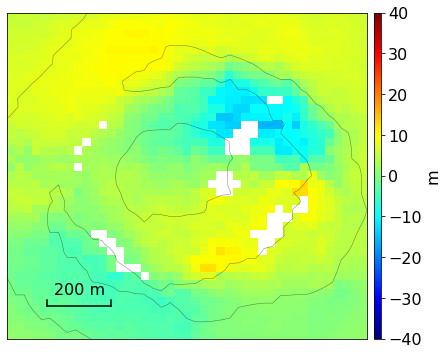

view.py /Users/yunjunz/data/archives/Kirishima/KirishimaAlosDT73/mintpy/demErr.h5 --mask /Users/yunjunz/data/archives/Kirishima/KirishimaAlosDT73/mintpy/maskTempCoh.h5 --dem /Users/yunjunz/data/archives/Kirishima/KirishimaAlosDT73/mintpy/inputs/geometryGeo.h5  -v -40 40 --dem-noshade --contour-step 100 --contour-smooth 0.0 --notitle --notick --noverbose  --sub-lat 31.906 31.917 --sub-lon 130.877 130.889 --noreference 


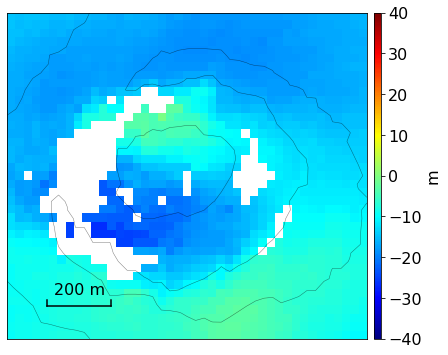

view.py /Users/yunjunz/data/archives/Kirishima/KirishimaAlos2AT131/mintpy/demErr.h5 --mask /Users/yunjunz/data/archives/Kirishima/KirishimaAlos2AT131/mintpy/maskTempCoh.h5 --dem /Users/yunjunz/data/archives/Kirishima/KirishimaAlos2AT131/mintpy/inputs/geometryGeo.h5  -v -80 80 --dem-noshade --contour-step 100 --contour-smooth 0.0 --notitle --notick --noverbose  --sub-lat 31.906 31.917 --sub-lon 130.877 130.889 --noreference 


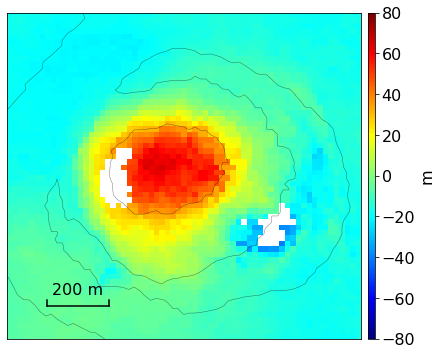

view.py /Users/yunjunz/data/archives/Kirishima/KirishimaAlos2DT23/mintpy/demErr.h5 --mask /Users/yunjunz/data/archives/Kirishima/KirishimaAlos2DT23/mintpy/maskTempCoh.h5 --dem /Users/yunjunz/data/archives/Kirishima/KirishimaAlos2DT23/mintpy/inputs/geometryGeo.h5  -v -80 80 --dem-noshade --contour-step 100 --contour-smooth 0.0 --notitle --notick --noverbose  --sub-lat 31.906 31.917 --sub-lon 130.877 130.889 --noreference 


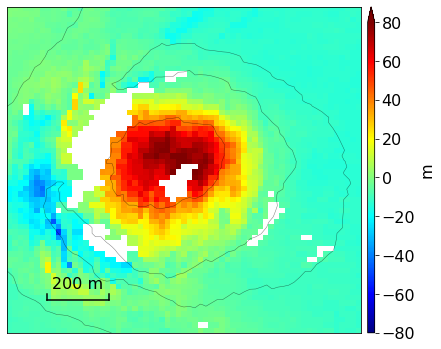

In [2]:
for proj_suffix, vmax in zip(['AlosAT424', 'AlosDT73', 'Alos2AT131', 'Alos2DT23'], [40, 40, 80, 80]):
    proj_dir = os.path.expanduser('~/data/archives/Kirishima/Kirishima{}/mintpy'.format(proj_suffix))

    dem_err_file = os.path.join(proj_dir, 'demErr.h5')
    mask_file = os.path.join(proj_dir, 'maskTempCoh.h5')
    dem_file = os.path.join(proj_dir, 'inputs/geometryGeo.h5')
    out_file = os.path.join(proj_dir, 'demErr_{}.png'.format(proj_suffix))

    scp_args = '{f} --mask {m} --dem {d} '.format(f=dem_err_file, m=mask_file, d=dem_file)
    scp_args += ' -v -{0} {0} --dem-noshade --contour-step 100 --contour-smooth 0.0 --notitle --notick --noverbose '.format(vmax)
    scp_args += ' --sub-lat {s} {n} --sub-lon {w} {e} --noreference '.format(s=S, n=N, w=W, e=E)
    print('view.py', scp_args)
    view.main(scp_args.split())

## 1-2. Discard noisy pixels (using `temp_coh`) and apply local referencing in space

In [3]:
for proj_suffix, vmax in zip(['AlosAT424', 'AlosDT73', 'Alos2AT131', 'Alos2DT23'], [40, 40, 80, 80]):
    proj_dir = os.path.expanduser('~/data/archives/Kirishima/Kirishima{}/mintpy'.format(proj_suffix))

    # input/output files
    dem_err_file = os.path.join(proj_dir, 'demErr.h5')
    tcoh_file    = os.path.join(proj_dir, 'temporalCoherence.h5')
    out_file     = os.path.join(proj_dir, 'ShinmoeLavaDome.h5')

    # read AOI
    geo_box = (W, N, E, S)
    atr = readfile.read_attribute(dem_err_file)
    pix_box = ut.coordinate(atr).box_geo2pixel(geo_box)
    dem_err = readfile.read(dem_err_file, box=pix_box)[0]
    # update attributes
    atr_out = attr.update_attribute4subset(atr, subset_box=pix_box)

    # mask
    tcoh = readfile.read(tcoh_file, box=pix_box)[0]
    dem_err[tcoh < 0.95] = np.nan

    # local reference
    coord = ut.coordinate(atr_out)
    y, x = coord.geo2radar(ref_lat, ref_lon)[:2]
    dem_err -= dem_err[y, x]
    # update attributes
    atr_out['REF_Y'] = y;  atr_out['REF_LAT'] = coord.radar2geo(y, x)[0]
    atr_out['REF_X'] = x;  atr_out['REF_LON'] = coord.radar2geo(y, x)[1]

    # deramp
    #dem_err, ramp = deramp(dem_err)

    # write
    writefile.write(dem_err, out_file, metadata=atr_out)

update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 205/227/248/266
update Y/X_FIRST
update REF_Y/X
delete exsited file: /Users/yunjunz/data/archives/Kirishima/KirishimaAlosAT424/mintpy/ShinmoeLavaDome.h5
create HDF5 file: /Users/yunjunz/data/archives/Kirishima/KirishimaAlosAT424/mintpy/ShinmoeLavaDome.h5 with w mode
create dataset /dem of float32    in size of (39, 43)             with compression=None
finished writing to /Users/yunjunz/data/archives/Kirishima/KirishimaAlosAT424/mintpy/ShinmoeLavaDome.h5
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 205/227/248/266
update Y/X_FIRST
update REF_Y/X
delete exsited file: /Users/yunjunz/data/archives/Kirishima/KirishimaAlosDT73/mintpy/ShinmoeLavaDome.h5
create HDF5 file: /Users/yunjunz/data/archives/Kirishima/KirishimaAlosDT73/mintpy/ShinmoeLavaDome.h5 with w mode
create dataset /dem of float32    in size of (39, 43)             with compression=None
finished writing to /Users/yunjunz/data/archives/Kir

## Create the crater mask

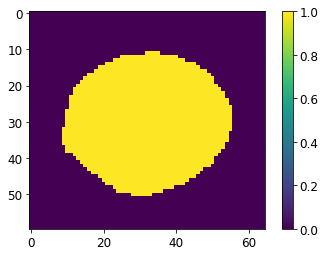

In [3]:
# read crater lat/lon from GMT xy text file
crater_lonlat_file = os.path.expanduser('~/Papers/2021_Kirishima/figs_src/data/Shinmoe_crater_lonlat.xy')
fc = np.loadtxt(crater_lonlat_file, dtype=bytes, comments='>').astype(float)
crater_lons = fc[:,0]
crater_lats = fc[:,1]

# crater lat/lon -> y/x
fname = os.path.expanduser('~/data/archives/Kirishima/KirishimaAlos2AT131/mintpy/ShinmoeLavaDome.h5')
atr = readfile.read_attribute(fname)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
coord = ut.coordinate(atr)
crater_ys, crater_xs = coord.geo2radar(crater_lats, crater_lons)[:2]

# yx -> polygon
polygon = []
for x, y in zip(crater_xs, crater_ys):
    polygon.append((x, y))
polygon.append((crater_xs[0], crater_ys[0]))

# polygon -> mask
mask = ut.polygon2mask(polygon, shape=[length, width])

# plot
fig, ax = plt.subplots(figsize=[6, 4])
im = ax.imshow(mask, interpolation='nearest')
fig.colorbar(im)
plt.show()

## 3. Calc the Lava Thickness from asc/desc orbits

In [4]:
dem_file = os.path.expanduser('~/data/archives/Kirishima/DEM/gsi10m.dem.wgs84')
fname1a = os.path.expanduser('~/data/archives/Kirishima/KirishimaAlos2AT131/mintpy/ShinmoeLavaDome.h5')
fname1d = os.path.expanduser('~/data/archives/Kirishima/KirishimaAlos2DT23/mintpy/ShinmoeLavaDome.h5')
dataA = readfile.read(fname1a)[0]
dataD = readfile.read(fname1d)[0]

# average between asc and desc
data = np.nanmean(np.array([dataA, dataD]), axis=0)
data_std = np.nanstd(np.array([dataA, dataD]), axis=0)

# fill the hole with nearest data
num_pixel2fill = np.sum(np.isnan(data) * mask)
print('number of pixels to fill: {}'.format(num_pixel2fill))
data = fill(data)

# ignore pixels outside of the crater
dataA[mask == 0] = np.nan
dataD[mask == 0] = np.nan
data[mask == 0] = np.nan
data_std[mask == 0] = np.nan

# set negative values to zero
print('number of pixels with values < 0: {}'.format(np.nansum(data[~np.isnan(data)] < 0)))

number of pixels to fill: 4
number of pixels with values < 0: 38


/Users/yunjunz/tools/miniconda3/envs/insar/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/yunjunz/tools/miniconda3/envs/insar/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


## 4. Calc the Volume

In [5]:
# get the pixel size
Re = 6.371e6 # earth radius in m
lat0 = float(atr['Y_FIRST'])
lat1 = float(atr['Y_STEP']) * length + lat0
latc = (lat0 + lat1) / 2
y_step = float(atr['Y_STEP']) * Re * np.pi / 180.
x_step = float(atr['X_STEP']) * Re * np.pi / 180. * np.cos(latc * np.pi / 180)

# calc the volume
vol     = np.nansum((data * abs(x_step) * abs(y_step)))
vol_std = np.nansum((data_std * abs(x_step) * abs(y_step)))

# msg
print('max height: {:.1f} m'.format(np.max(data[mask])))
print('estimated volume (3 STD): {:.2e} +/- {:.1e} m^3'.format(vol, vol_std*3))

max height: 90.8 m
estimated volume (3 STD): 1.51e+07 +/- 4.3e+06 m^3


## Plot - Map

save figure to file /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs/ShinmoeLavaThicknessMap.png


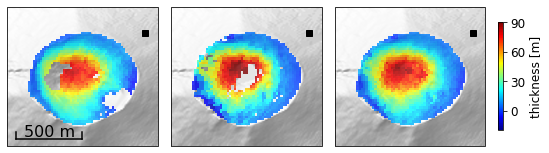

In [6]:
# view options5
opt = 'view.py {} --dem {} --dem-nocontour --contour-step 50 --contour-smooth 0 '.format(fname1a, dem_file)
opt += ' --notitle --notick --noverbose --nocolorbar '
opt += ' -v -20 90 -c jet '

# plot
kwargs = dict(vmin=-40, vmax=80, cmap='jet', interpolation='nearest')
subplot_kw = dict(projection=ccrs.PlateCarree())
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[7, 2.5], subplot_kw=subplot_kw)

opt2s = [
    ' --lalo-loc 1 0 1 0 --scalebar 0.4 0.28 0.05 ',
    ' --lalo-loc 0 0 1 0 --noscalebar ',
    ' --lalo-loc 0 0 1 0 --noscalebar ',
]
for ax, dv, opt2 in zip(axs, [dataA, dataD, data], opt2s):
    # plot map via view
    atr, inps = view.prep_slice(opt + opt2)[1:]
    im = view.plot_slice(ax, dv, atr, inps)[2]

# axis format
fig.tight_layout()

# colorbar
cax = fig.add_axes([1.0, 0.2, 0.01, 0.6])
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[0, 30, 60, 90])
cbar.set_label('thickness [m]')

# output
out_fig = os.path.join(work_dir, 'ShinmoeLavaThicknessMap.png')
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
print('save figure to file', out_fig)
plt.show()

## Plot - Histogram

save figure to file /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs/ShinmoeLavaThicknessHist.png


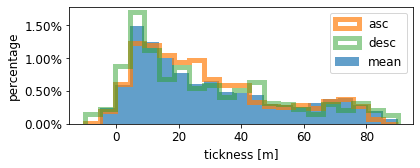

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6, 2.5])
ax.hist(dataA[mask], bins=21, range=(-10, 90), density=True, alpha=0.7, lw=5.0, histtype='step', ec='C1', label='asc')
ax.hist(dataD[mask], bins=21, range=(-10, 90), density=True, alpha=0.5, lw=5.0, histtype='step', ec='C2', label='desc')
ax.hist(data[mask],  bins=21, range=(-10, 90), density=True, alpha=0.7, lw=5.0, histtype='bar',  fc='C0', label='mean')

# axis format
ax.yaxis.set_major_formatter(ticker.PercentFormatter(2))
ax.set_xlabel('tickness [m]')
ax.set_ylabel('percentage')
ax.legend()
fig.tight_layout()

#output
out_fig = os.path.join(work_dir, 'ShinmoeLavaThicknessHist.png')
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
print('save figure to file', out_fig)
plt.show()

## 5. DEM: Old vs. New

reading DEM: gsi10m.dem.wgs84 ...
height difference between ellipsoid and geoid: 31.8 m


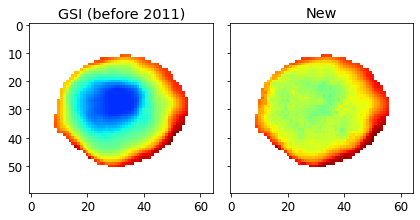

In [10]:
gsi1_file = os.path.expanduser('~/data/archives/Kirishima/KirishimaAlos2AT131/mintpy/inputs/gsi10m.dem.wgs84')
dem_gsi1 = pp.read_dem(gsi1_file, geo_box=(W, N, E, S))[0]

# resample to the same lower resolution as used during InSAR time series analysis
dem_gsi = resize(dem_gsi1, (length, width), order=1, mode='constant', anti_aliasing=True, preserve_range=True)

# ellipsoid -> geoid
egm_file = os.path.join(os.path.dirname(geoid.__file__), 'geoids/egm2008-1.pgm')
gh_obj = geoid.GeoidHeight(egm_file)
h_offset = gh_obj.get(lat=ref_lat, lon=ref_lon)
print('height difference between ellipsoid and geoid: {:.1f} m'.format(h_offset))
dem_gsi -= h_offset
dem_gsi[np.isnan(data)] = np.nan

# new DEM
dem_new = dem_gsi + data

# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[6, 3], sharey=True)
kwargs = dict(vmin=1200, vmax = 1421, cmap='jet', interpolation='nearest')
for ax, dem, title in zip(axs, [dem_gsi, dem_new], ['GSI (before 2011)', 'New']):
    ax.imshow(dem, **kwargs)
    ax.set_title(title)

# axis format
fig.tight_layout()
plt.show()